## Формулировка задачи

В датасете представлена статистика активности клиентов оператора мобильной связи. Признаками являются количество совершенных звонков, общее число минут разговора, отправленныз СМС и Мб Интернет-сессий за период времени. Целевым признаком является используемый тариф Ultra или Smart.
<p>Необходимо подобрать модель, наиболее точно предсказывающую склонность того или иного клиента к тарифному плану Ultra, либо Smart.

Описание исходных данных:
<p>
    
Датасет <b>`users`</b>:
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана.
    
</p>
<br>
<p>
    
Датасет <b>`calls`</b>:
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок.

</p>
<br>
<p>
    
Датасет <b>`messages`</b>:
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение.

</p>
<br>
<p>

Датасет <b>`internet`</b>:
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в Mb)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя.

</p>
<br>
<p>

Датасет <b>`tariffs`</b>:
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в Mb)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета.

## 1. Обзор данных

In [31]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st

In [6]:
calls = pd.read_csv('datasets/calls.csv')
messages = pd.read_csv('datasets/messages.csv')
internet = pd.read_csv('datasets/internet.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')

<b>Проверка датасета `calls`.</b>

In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [12]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

In [13]:
print(calls['call_date'].min())
print(calls['call_date'].max())

2018-01-01
2018-12-31


Датасет `calls` содержит 202 607 строк и является самым большим из 5 датасетов.
Пропущенных значений нет.
`call_date` необходимо будет привести к формату DateTime.
Средняя продолжительность звонков около 7 мин., максимальная - 38 мин.
Даты корректны: датасет покрывает с первого по последний день 2018 года.

<b>Проверка датасета `messages`.</b>

In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
print(messages['message_date'].min())
print(messages['message_date'].max())

2018-01-02
2018-12-31


Датасет `messages` содержит 123 036 строк.
Пропущенных значений нет.
message_date необходимо будет привести к формату DateTime.
Даты корректны: датасет покрывает с первого по последний день 2018 года.

<b>Проверка датасета `internet`.</b>

In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [21]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [22]:
print(internet['session_date'].min())
print(internet['session_date'].max())

2018-01-01
2018-12-31


Датасет `internet` содержит 149 396 строк.
Пропущенных значений нет.
session_date необходимо будет привести к формату DateTime.
Средний расход пользователя за 1 сессию - 370 Мб, максимальный - 1 725 Мб.
Даты корректны: датасет покрывает с первого по последний день 2018 года.

<b>Проверка датасета `tariffs`.</b>

In [25]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Датасет `tariffs` содержит 2 строки.
Пропущенных значений нет.

<b>Проверка датасета `users`.</b>

In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [27]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [28]:
print(users['reg_date'].min())
print(users['reg_date'].max())

2018-01-01
2018-12-31


Датасет `users` содержит 500 строк.
Пропущенных значений (кроме столбца churn_date) нет.
churn_date необходимо будет привести к формату DateTime.
reg_date необходимо будет привести к формату DateTime.
Средний возраст пользователей - 46 лет, минимальный - 18 лет, максимальный - 75 лет.
Даты корректны: датасет покрывает с первого по последний день 2018 года.

Пропусков и ошибок в данных не обнаружено.
Столбцы, содежащие даты требуют приведения к корректному формату.

## 2. Предобработка данных

### 2.1. Приведение данных к необходимым форматам

Приведем к dateTime столбцы датасетов, содержащие даты (иначе не удастся достать месяц и сгруппировать по нему).

In [29]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

### 2.2. Округление времени звонков

Согласно тарификации оператора, каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

In [32]:
calls['duration'] = calls['duration'].apply(math.ceil)

### 2.3. Группировка данных

Сгруппируем данные датасетов по `user_id` и месяцам.

In [33]:
# Данные датасета со звонками.

calls['month'] = calls['call_date'].dt.month_name()

calls = calls.groupby(['user_id', 'month'])\
                .agg({'id':'count', 'duration':'sum'})\
                .rename(columns={'id':'calls_count_month',
                                 'duration':'calls_duration_month'})\
                .reset_index()
calls.head(5)

,user_id,month,calls_count_month,calls_duration_month
0,1000,August,52,408
1,1000,December,46,333
2,1000,July,47,340
3,1000,June,43,172
4,1000,May,22,159


In [34]:
# Данные датасета с сообщениями.

messages['month'] = messages['message_date'].dt.month_name()

messages = messages.groupby(['user_id', 'month'])\
                .agg({'id':'count'})\
                .rename(columns={'id':'messages_count_month'})\
                .reset_index()

messages.head(5)

,user_id,month,messages_count_month
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


In [35]:
# Данные датасета с Интернет-траффиком.

internet['month'] = internet['session_date'].dt.month_name()

internet = internet.groupby(['user_id', 'month'])\
                .agg({'id':'count', 'mb_used':'sum'})\
                .rename(columns={'id':'sessions_count_month',
                                'mb_used':'mb_used_month'})\
                .reset_index()              
internet.head(5)

,user_id,month,sessions_count_month,mb_used_month
0,1000,August,29,14055.93
1,1000,December,21,9817.61
2,1000,July,29,14003.64
3,1000,June,49,23233.77
4,1000,May,5,2253.49


### 2.4. Округление интернет-траффика

In [36]:
def mb_to_gb(item):
    if item > 1024:
        return math.ceil(item / 1024)
    else:
        return 1

internet['gb_used_month'] = internet['mb_used_month'].apply(mb_to_gb)

internet.sample(5)

,user_id,month,sessions_count_month,mb_used_month,gb_used_month
1450,1227,January,50,16626.17,17
1351,1211,December,51,16900.63,17
2991,1468,April,30,11204.56,11
2377,1376,October,58,21214.67,21
316,1051,July,59,20882.89,21


### 2.5. Расчет выручки

Сджойним таблицы со звонками, сообщениями и траффиком.
Джойним к таблице calls, поскольку она является наиболее объемной.

In [37]:
df = calls.merge(messages, on=['user_id','month'], how='outer')
df = df.merge(internet, on=['user_id','month'], how='outer')
df = df.merge(users, on='user_id', how='left')

Перед тем как джойнить df с таблицей tariffs, переименуем столбец tariff.

In [39]:
df = df.rename(columns = {
    'tariff': 'tariff_name'})

df = df.merge(tariffs, on='tariff_name', how='left')

df.columns

Index(['user_id', 'month', 'calls_count_month', 'calls_duration_month',
       'messages_count_month', 'sessions_count_month', 'mb_used_month',
       'gb_used_month', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute'],
      dtype='object')

Расположим столбцы полученного датасета более логично.

In [40]:
df = df[['user_id',
         'first_name',
         'last_name',
         'city',
         'age',
         'tariff_name',
         'reg_date',
         'churn_date',
         'month',
         'calls_count_month',
         'calls_duration_month',
         'messages_count_month',
         'sessions_count_month',
         'mb_used_month',
         'gb_used_month',
         'messages_included',
         'mb_per_month_included',
         'minutes_included',
         'rub_monthly_fee',
         'rub_per_gb',
         'rub_per_message',
         'rub_per_minute']]

df.sample(5)

,user_id,first_name,last_name,city,age,tariff_name,reg_date,churn_date,month,calls_count_month,...,sessions_count_month,mb_used_month,gb_used_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
2366,1377,Альфред,Семин,Брянск,59,ultra,2018-02-25,NaT,November,164.0,...,10.0,5998.50,6.0,1000,30720,3000,1950,150,1,1
64,1009,Василиса,Блинова,Пермь,24,smart,2018-03-22,NaT,August,33.0,...,65.0,23708.41,24.0,50,15360,500,550,200,3,3
2548,1402,Мариетта,Измайлова,Пенза,23,ultra,2018-03-09,NaT,August,90.0,...,62.0,31566.08,31.0,1000,30720,3000,1950,150,1,1
2971,1467,Исак,Александрюк,Киров,66,ultra,2018-11-24,NaT,December,244.0,...,22.0,9756.90,10.0,1000,30720,3000,1950,150,1,1
1676,1269,Аким,Ахмадулин,Омск,31,smart,2018-07-17,NaT,December,45.0,...,56.0,17969.07,18.0,50,15360,500,550,200,3,3


Проверим датасет на наличие дубликатов.

In [41]:
df.duplicated().sum()

0

Проверим датасет на наличие пропусков.

In [42]:
df.isnull().sum()

user_id                     0
first_name                  0
last_name                   0
city                        0
age                         0
tariff_name                 0
reg_date                    0
churn_date               3027
month                       0
calls_count_month          40
calls_duration_month       40
messages_count_month      497
sessions_count_month       11
mb_used_month              11
gb_used_month              11
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Заполним пропущенные значения нулями (кроме churn_date), предполагая, что клиенты не пользовались данными сервисами.

In [43]:
df['calls_count_month'] = df['calls_count_month'].fillna(0)
df['calls_duration_month'] = df['calls_duration_month'].fillna(0)
df['messages_count_month'] = df['messages_count_month'].fillna(0)
df['sessions_count_month'] = df['sessions_count_month'].fillna(0)
df['mb_used_month'] = df['mb_used_month'].fillna(0)
df['gb_used_month'] = df['gb_used_month'].fillna(0)

In [44]:
df.isnull().sum()

user_id                     0
first_name                  0
last_name                   0
city                        0
age                         0
tariff_name                 0
reg_date                    0
churn_date               3027
month                       0
calls_count_month           0
calls_duration_month        0
messages_count_month        0
sessions_count_month        0
mb_used_month               0
gb_used_month               0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Рассчитаем помесячную выручку с каждого пользователя.
Сначала инкрементальную (за превышение лимитов тарифа).

In [46]:
def over_tariff(row):
        cls = (row['calls_duration_month'] - row['minutes_included']) * row['rub_per_minute']
        msg = (row['messages_count_month'] - row['messages_included']) * row['rub_per_message']
        gb = (row['gb_used_month'] - math.ceil(row['mb_per_month_included']/1024)) * row['rub_per_gb']
        
        incr_revenue = 0
        
        for i in [cls, msg, gb]:
            if i>0:
                incr_revenue += i
        return incr_revenue

df['incr_revenue'] = df.apply(lambda x: over_tariff(x), axis=1)

Сложим инкрементальную выручку с абонентской платой

In [47]:
df['total_revenue'] = df['incr_revenue'] + df['rub_monthly_fee']
df.sample(5)

,user_id,first_name,last_name,city,age,tariff_name,reg_date,churn_date,month,calls_count_month,...,gb_used_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,incr_revenue,total_revenue
1835,1292,Веселина,Алексеенко,Красноярск,63,ultra,2018-02-21,NaT,September,31.0,...,34.0,1000,30720,3000,1950,150,1,1,600.0,2550.0
1918,1307,Симона,Авсейкина,Самара,53,smart,2018-05-04,NaT,June,76.0,...,18.0,50,15360,500,550,200,3,3,1074.0,1624.0
2911,1458,Роберт,Азаров,Барнаул,36,ultra,2018-02-13,NaT,August,117.0,...,14.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
225,1035,Розалия,Аракина,Тюмень,37,smart,2018-04-03,NaT,July,60.0,...,14.0,50,15360,500,550,200,3,3,39.0,589.0
1480,1238,Радислав,Наумов,Ростов-на-Дону,57,smart,2018-01-08,NaT,June,4.0,...,13.0,50,15360,500,550,200,3,3,0.0,550.0


In [48]:
df.pivot_table(index = ['tariff_name'],
                     values = ['rub_monthly_fee', 'incr_revenue', 'total_revenue'],
                     aggfunc = ['count', 'sum']) 

count                                        sum  \
            incr_revenue rub_monthly_fee total_revenue incr_revenue   
tariff_name                                                           
smart               2229            2229          2229    1649401.0   
ultra                985             985           985     118350.0   

                                           
            rub_monthly_fee total_revenue  
tariff_name                                
smart               1225950     2875351.0  
ultra               1920750     2039100.0

Тариф `Smart` используют 69% клиентов, он генерирует 58% всей выручки, 57% от которой приходится на услуги сверх абонентской платы.

Тариф `Ultra` использует 31% клиентов, он генерирует 42% всей выручки, услуги сверх абонентской платы приносят около 6% инкрементальной прибыли.

Данные были приведены к необходимым форматам (dateTime, округление времени разговора до минут и траффика до Гб, сообразно тарифам оператора), осуществлена проверка дубликатов строк (не выявлено) и наличие пробелов (заменены на 0, где приемлемо).
Собран единый датасет из 5 таблиц, упорядоченный по абоненту и отчетному месяцу.
Добавлены столбцы с инкрементальной (за превышение лимитов тарифа абонентом) и общей выручки для каждого абонента.
Проведено сравнение двух тарифных планов оператора, из которого следет, что бОльшая часть выручки Smart формирует инкрементальная плата абонента за услуги выше тарифных лимитов.

## 3. Анализ использования тарифных планов клиентами

### 3.1. Минуты разговора

In [50]:
df_smart = df.loc[df['tariff_name'] == 'smart']
df_ultra = df.loc[df['tariff_name'] == 'ultra']

df.groupby('tariff_name')\
  .agg({'calls_duration_month':['mean','median','var','std']})\
  .style.format("{:.2f}")

В среднем, пользователи `Smart` разговаривают на 20% меньше пользователей `Ultra` (418 мин. vs 527 мин.)

<AxesSubplot:title={'center':'Распределение времени разговора клиентов, мин/мес'}, ylabel='Frequency'>

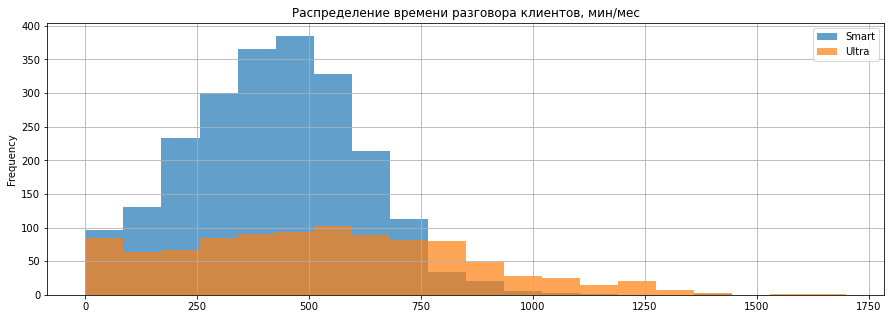

In [51]:
ax = df_smart['calls_duration_month'].plot(
    kind='hist',
    y='time_spent',
    range=(0, 1700),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='Smart',
    legend=True,
    figsize=(15, 5),
    title='Распределение времени разговора клиентов, мин/мес'
)

df_ultra['calls_duration_month'].plot(
    kind='hist',
    y='time_spent',
    range=(0, 1700),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='Ultra',
    ax=ax,
    grid=True,
    legend=True,
)

Польователи `Ultra` более равномерны в числе звонковых минут, в то время как у `Smart` набюдается нормальное распределение.

### 3.2. Анализ отправляемых сообщений

In [52]:
df.groupby('tariff_name')\
  .agg({'messages_count_month':['mean','median','var','std']})\
  .style.format("{:.2f}")

<AxesSubplot:title={'center':'Распределение числа SMS клиентов, SMS/мес'}, ylabel='Frequency'>

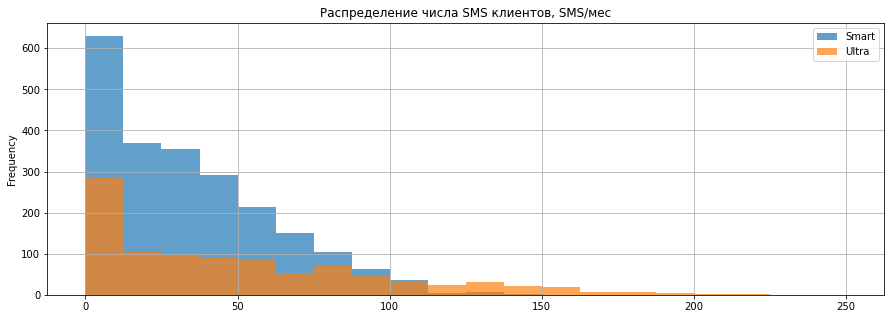

In [53]:
ax = df_smart['messages_count_month'].plot(
    kind='hist',
    y='time_spent',
    range=(0, 250),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='Smart',
    legend=True,
    figsize=(15, 5),
    title='Распределение числа SMS клиентов, SMS/мес'
)

df_ultra['messages_count_month'].plot(
    kind='hist',
    y='time_spent',
    range=(0, 250),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='Ultra',
    ax=ax,
    grid=True,
    legend=True,
)

Пользователи обоих тарифов отправляют примерно одинковое число СМС (28 - `Smart` , 38 - `Ultra`).
По большому счету, они укладываются в 50 СМС и необходимости в пакете из 1 000 сообщений на `Ultra` нет

### 3.3. Анализ Интернет-траффика

In [54]:
df.groupby('tariff_name')\
  .agg({'gb_used_month':['mean','median','var','std']})\
  .style.format("{:.2f}")

<AxesSubplot:title={'center':'Распределение Интернет-траффика клиентов, Гб/мес'}, ylabel='Frequency'>

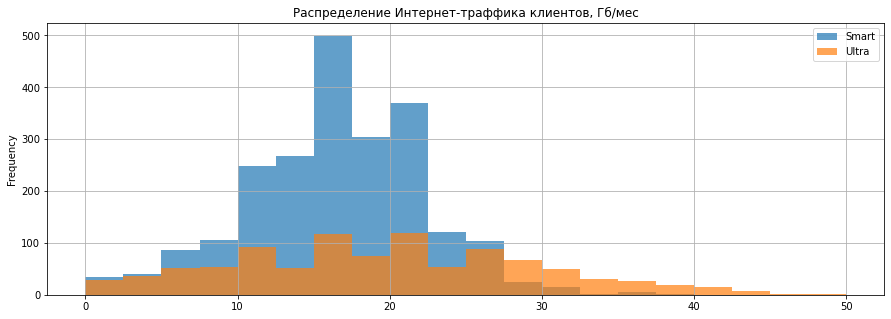

In [55]:
ax = df_smart['gb_used_month'].plot(
    kind='hist',
    y='time_spent',
    range=(0, 50),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='Smart',
    legend=True,
    figsize=(15, 5),
    title='Распределение Интернет-траффика клиентов, Гб/мес'
)

df_ultra['gb_used_month'].plot(
    kind='hist',
    y='time_spent',
    range=(0, 50),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='Ultra',
    ax=ax,
    grid=True,
    legend=True,
)

Пользователи `Ultra` более активны в Интернете (расход траффика больше), большинство из них укладывается в педоставленные 30 Гб, чего нельзя сказать о клиентах на `Smart`, поскольку бОльшая часть из них выходит за рамки предоставленных 15 Гб.

## 4. Проверка гипотез

### 4.1. Гипотеза о различии выручки тарифов

Мы имеем следующие гипотезы:
<br>H0: средняя выручка клиентов на тарифах Smart и Ultra не различается;
<br>H1: средняя выручка клиентов на тарифах Smart и Ultra различается.

<br>Для анализа тарифов используется t-критерий Стьюдента, так как сравниваемые выборки независимы друг от друга.

In [56]:
result = st.ttest_ind(df_smart['total_revenue'], df_ultra['total_revenue'])

alpha = .05

print('p-значение: ', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  1.4229814360764067e-160
Отвергаем нулевую гипотезу


Между выручкой от тарифа `Smart` и выручкой от тарифа `Ultra` имеются значимые различия.

### 4.2. Гипотеза о региональных различиях выручки

In [57]:
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [58]:
msk = df_smart = df.loc[df['city'] == 'Москва']
non_msk = df_smart = df.loc[df['city'] != 'Москва']

results = st.ttest_ind(msk['total_revenue'], non_msk['total_revenue'])

alpha = 0.05

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Между выручкой от клиентов из Москвы и выручкой от клиентов из других регионов не имеется значимых различий.

## 5. Итоги исследования

Нами получены следующие результаты сравнения активности пользователей на тарифах:

* средняя выручка пользователей с тарифом Smart отличается от средней выручки пользователей с траифом Ultra за счет абонентской платы (а не оплаты сервисов сверх тарифа), несмотря на то, что пользователей тарифа Ultra вдвое больше, чем пользовтаелей тарифа Smart;
* средняя выручка в Москве и других регионах значимо не различается, рекламу можно запускать по всей территории присутсвия оператора;
* сообщения можно убрать из наполнения тарифов, поскольку они используются незначительно;
* если косты оператора поволяют, следует наращивать базу клиентов Ultra, а не Smart, посколкьу данный тариф приносит больше ревенью и комфортнее для абонентов (выход за рамки тарифных лимитов менее вероятен на Ultra).